# Alfred the Mail Sorting Butler: A LangGraph Example

In this notebook, **we're going to build a complete email processing workflow using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

## What You'll Learn

In this notebook, you'll learn how to:
1. Set up a LangGraph workflow
2. Define state and nodes for email processing
3. Create conditional branching in a graph
4. Connect an LLM for classification and content generation
5. Visualize the workflow graph
6. Execute the workflow with example data

In [1]:
# Install the required packages
%pip install -q langgraph langchain_openai langchain_huggingface

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setting Up Our Environment

First, let's import all the necessary libraries. LangGraph provides the graph structure, while LangChain offers convenient interfaces for working with LLMs.

In [ ]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = "sk-xxxxx"  # Replace with your actual API key

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## Step 1: Define Our State

In LangGraph, **State** is the central concept. It represents all the information that flows through our workflow.

For Alfred's email processing system, we need to track:
- The email being processed
- Whether it's spam or not
- The draft response (for legitimate emails)
- Conversation history with the LLM

In [ ]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

## Step 2: Define Our Nodes

In [ ]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint



# Initialize LLM
model = ChatOpenAI( model="gpt-4o",temperature=0)

class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

# Define nodes
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}

def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler of Mr wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr wayne's attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only reurn the answer
Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content}
        ]
    else :
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}

def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "draft_response": response.content,
        "messages": new_messages
    }

def notify_mr_wayne(state: EmailState):
    email = state["email"]

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")

    return {}

# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email) # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email) # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam) #same logic
email_graph.add_node("drafting_response", drafting_response) #same logic
email_graph.add_node("notify_mr_wayne", notify_mr_wayne) # same logic


## Step 3: Define Our Routing Logic

In [ ]:
# Add edges
email_graph.add_edge(START, "read_email") # After starting we go to the "read_email" node

email_graph.add_edge("read_email", "classify_email") # after_reading we classify

# Add conditional edges
email_graph.add_conditional_edges(
    "classify_email", # after classify, we run the "route_email" function"
    route_email,
    {
        "spam": "handle_spam", # if it return "Spam", we go the "handle_span" node
        "legitimate": "drafting_response" # and if it's legitimate, we go to the "drafting response" node
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END) # after handling spam we always end
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END) # after notifyinf Me wayne, we can end  too


## Step 4: Create the StateGraph and Define Edges

In [ ]:
# Compile the graph
compiled_graph = email_graph.compile()

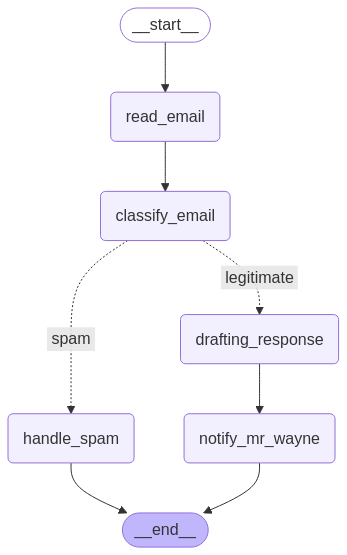

In [ ]:

from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [ ]:
 # Example emails for testing
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman!

Dear Mr. Joker,

Thank you for reaching out. Your message has been received and noted. Mr. Wayne is currently unavailable, but rest assured, your concerns will be addressed in due course.

Kind regards,

Alfred Pennyworth  
Personal Assistant to Bruce Wayne


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email has been moved to the spam folder.


# langfuse part

In [ ]:
%pip install -q langfuse

we pip install Langchain (LangChain is required because we use LangFuse)

In [ ]:
%pip install langchain

Next, we add the Langfuse API keys and host address as environment variables. You can get your Langfuse credentials by signing up for Langfuse Cloud or self-host Langfuse.

In [ ]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-..." 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-..."
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # 🇪🇺 EU region
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

Then, we configure the Langfuse callback_handler and instrument the agent by adding the langfuse_callback to the invocation of the graph: config={"callbacks": [langfuse_handler]}.

In [ ]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

# Process legitimate email
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None, "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

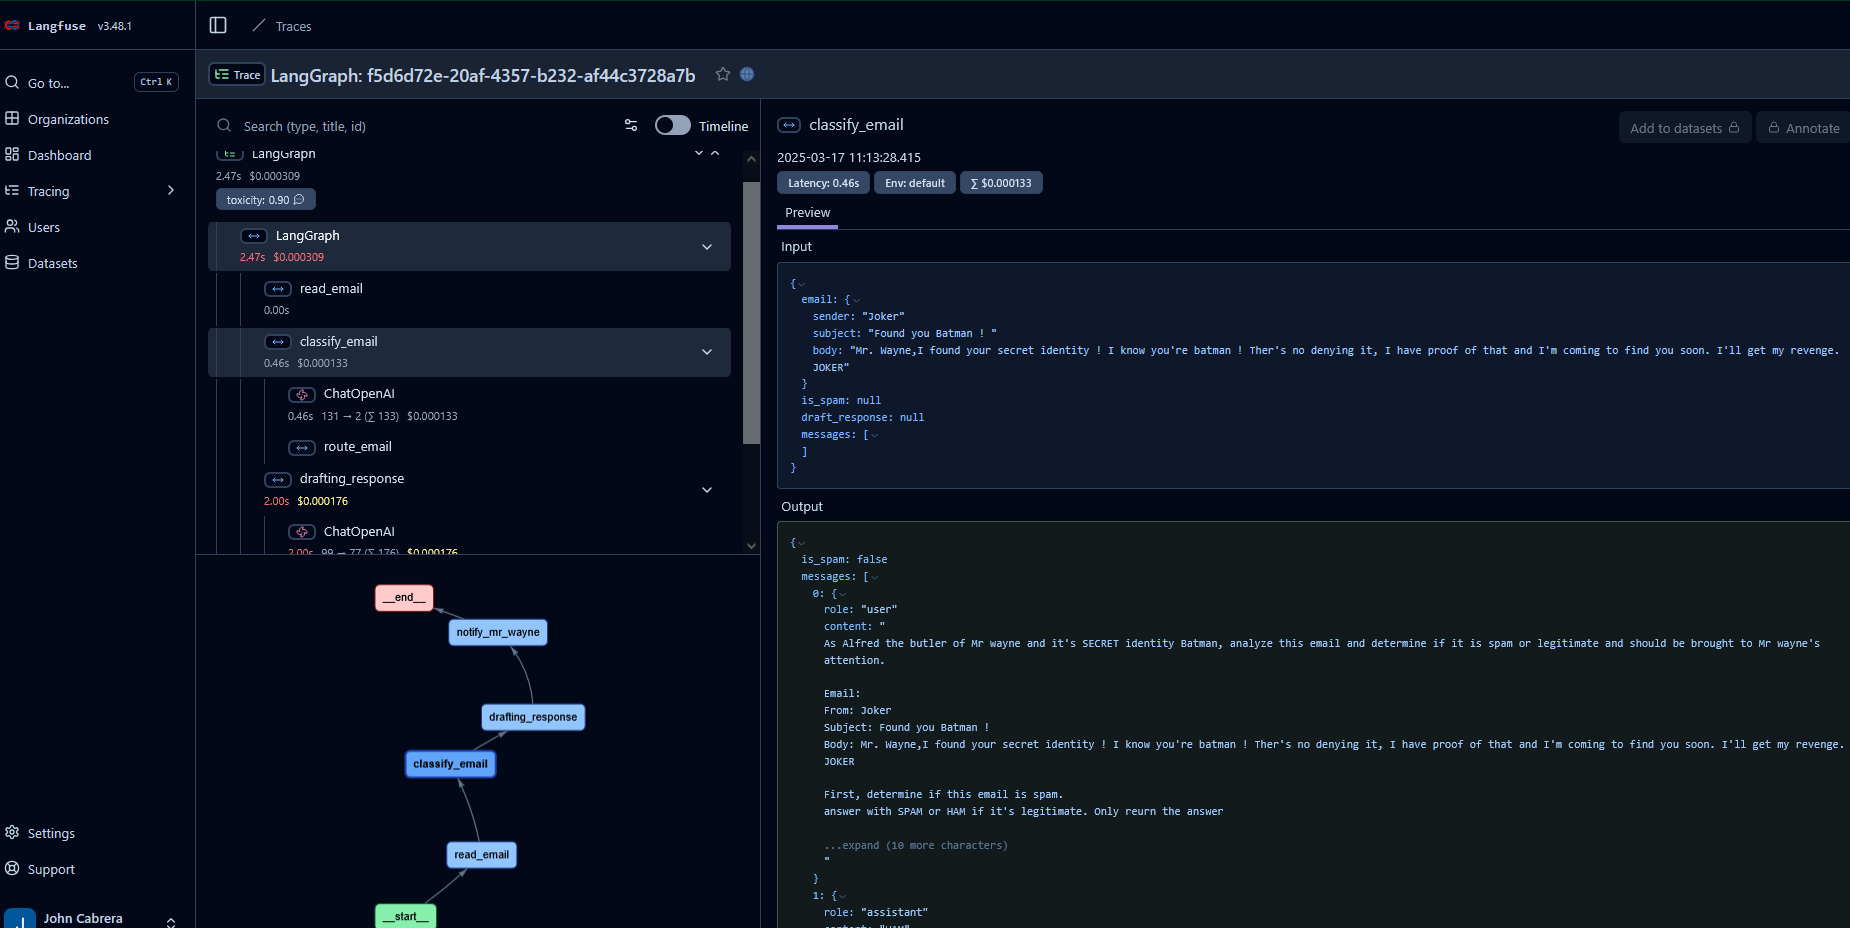